Fitted params from 0A (HQ875 baseline):
  H: eps = 1.321e-06 m·rad, sigma_delta = 5.723e-04
  V: eps = 8.968e-07 m·rad, sigma_delta = 0.000e+00 (expect ~0)

Files used:
  HQ875 -35A -> twiss_Q875_baseline_-35a_flipPol.tfs
  HQ875 -28A -> twiss_Q875_baseline_-28a_flipPol.tfs
  HQ875 -21A -> twiss_Q875_baseline_-21a_flipPol.tfs
  HQ875 -14A -> twiss_Q875_baseline_-14a_flipPol.tfs
  HQ875 -7A -> twiss_Q875_baseline_-7a_flipPol.tfs
  HQ875 Baseline -> twiss_Q875_baseline_default_flipPol.tfs
  HQ875 +7A -> twiss_Q875_baseline_+7a_flipPol.tfs
  HQ875 +14A -> twiss_Q875_baseline_+14a_flipPol.tfs
  HQ875 +21A -> twiss_Q875_baseline_+21a_flipPol.tfs
  HQ875 +28A -> twiss_Q875_baseline_+28a_flipPol.tfs


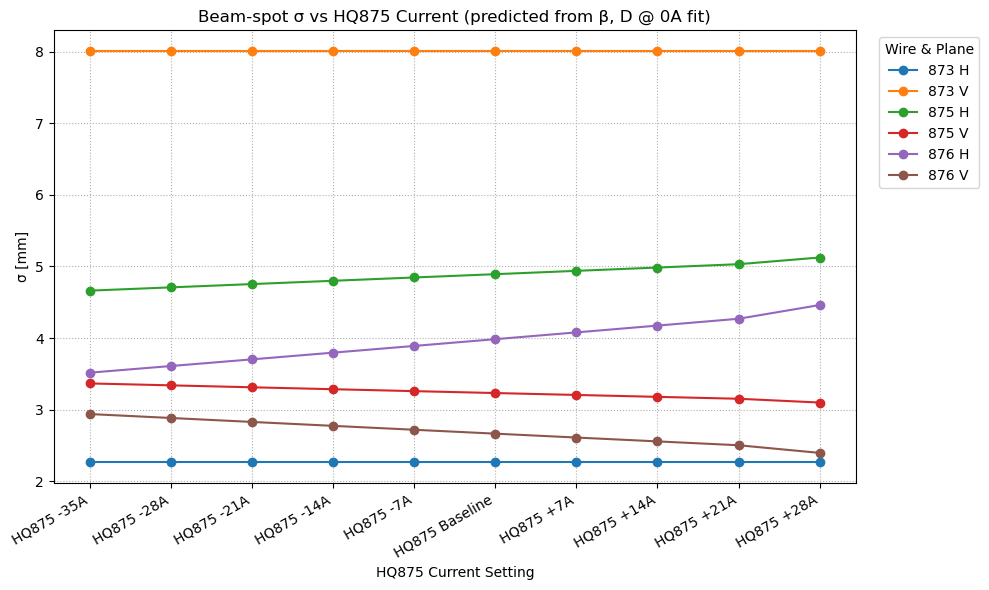


Wrote madx_pred_sigma_vs_current_HQ875_flipPol.csv


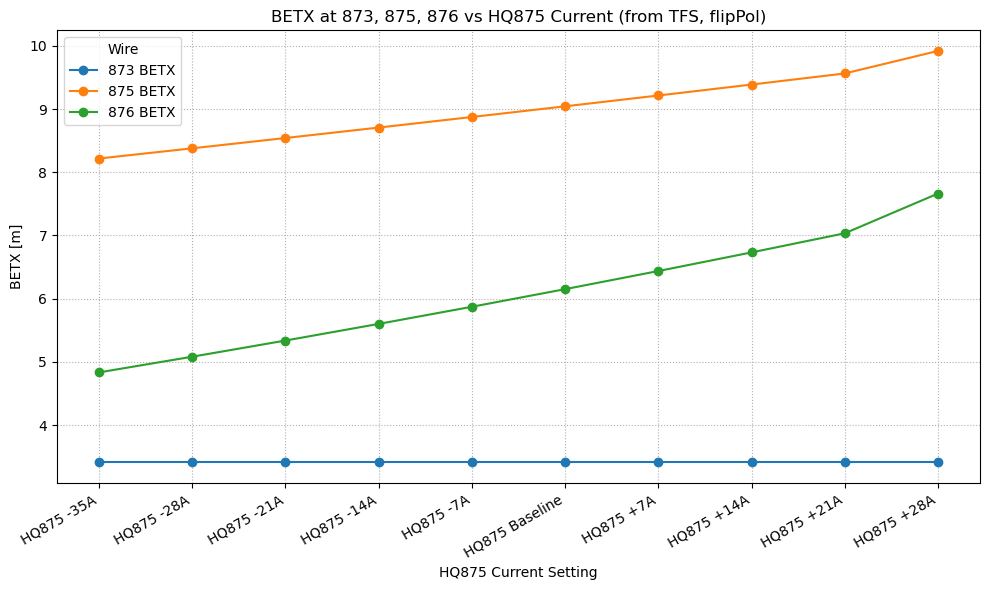

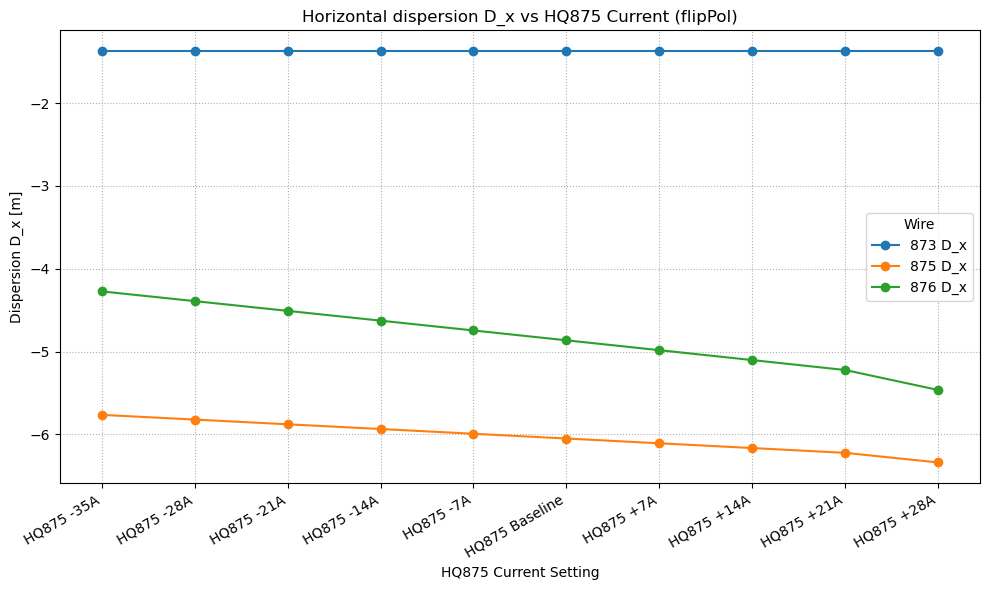

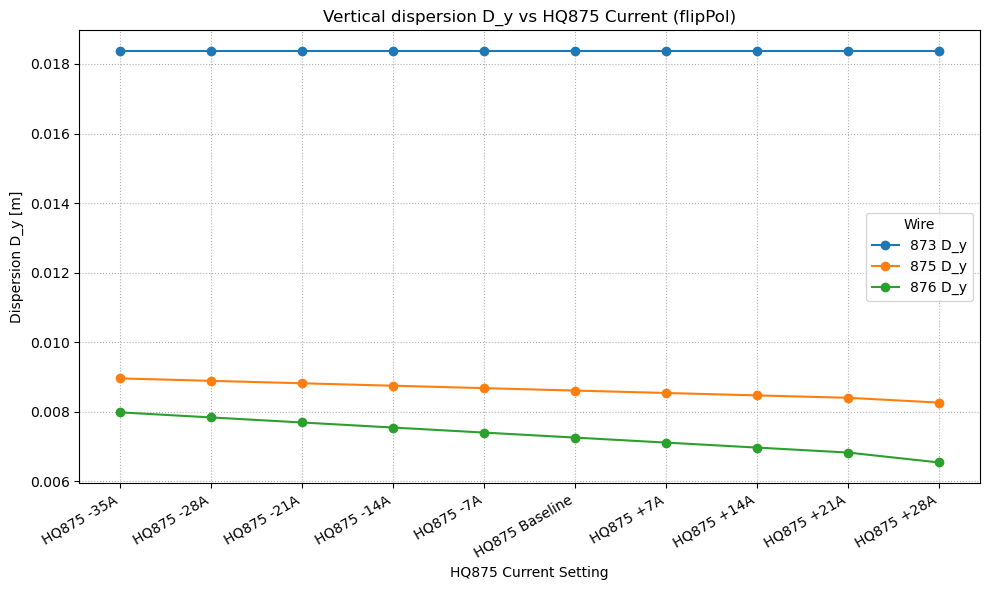

Wrote betax_vs_HQ875_current_flipPol.csv and dispersion_vs_HQ875_current_flipPol.csv


In [1]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# Config: magnet labels + where to look for files
#   - MAGNET_FILE_TAG must match filenames (files use "Q875")
#   - MAGNET_LABEL is what shows up on plots ("HQ875")
# =============================================================================
MAGNET_FILE_TAG = "Q875"
MAGNET_LABEL    = "HQ875"
USE_FLIPPED     = True  # using *_flipPol.tfs

# If needed, adjust which wires we care about and the baseline measured σ (mm)
# TODO: replace with HQ875 monitor set and measured baseline sigmas.
monitors = ["MW873","MW875","MW876"]
baseline_measured_mm = {
    ("MW873","H"): 2.30, ("MW873","V"): 5.00,
    ("MW875","H"): 5.00, ("MW875","V"): 1.37,
    ("MW876","H"): 3.77, ("MW876","V"): 0.969,
}

# =============================================================================
# Discover available HQ875 files in the current directory
# Expected pattern examples:
#   twiss_Q875_baseline_flipPol.tfs               -> baseline (0 A)
#   twiss_Q875_baseline_default_flipPol.tfs       -> baseline (0 A)
#   twiss_Q875_baseline_-35a_flipPol.tfs          -> -35 A
#   twiss_Q875_baseline_+28a_flipPol.tfs          -> +28 A
# Also tolerate legacy alternates: twiss_Q875_+9A_flipPol.tfs, twiss_Q875_default.tfs, etc.
# =============================================================================
def discover_q875_files(use_flipped=True):
    files = {}
    entries = os.listdir(".")
    suffix = r"_flipPol\.tfs$" if use_flipped else r"\.tfs$"

    # 0A baseline variants first
    baseline_variants = [
        rf"^twiss_{MAGNET_FILE_TAG}_baseline{suffix}",
        rf"^twiss_{MAGNET_FILE_TAG}_baseline_default{suffix}",
    ]
    for nm in entries:
        for pat in baseline_variants:
            if re.fullmatch(pat, nm, re.IGNORECASE):
                files["0"] = nm
                break

    # Primary current-tagged pattern under 'baseline_*a'
    base_curr_rx = re.compile(
        rf"^twiss_{MAGNET_FILE_TAG}_baseline_(?P<curr>[+-]?\d+(?:\.\d+)?)a{suffix}",
        re.IGNORECASE
    )
    for name in entries:
        m = base_curr_rx.match(name)
        if m:
            key = m.group("curr")
            files[key] = name

    # Legacy: twiss_Q875_+9A_flipPol.tfs
    legacy_rx = re.compile(
        rf"^twiss_{MAGNET_FILE_TAG}_(?P<curr>[+-]?\d+(?:\.\d+)?)[aA]{suffix}",
        re.IGNORECASE
    )
    for nm in entries:
        m = legacy_rx.match(nm)
        if m:
            key = m.group("curr")
            files.setdefault(key, nm)

    # Fallback legacy 0A: twiss_Q875_default.tfs (rare)
    if "0" not in files:
        for nm in entries:
            if re.fullmatch(rf"^twiss_{MAGNET_FILE_TAG}_default\.tfs$", nm, re.IGNORECASE):
                files["0"] = nm
                break

    if not files:
        raise RuntimeError("No HQ875 (Q875) twiss files found in the current directory.")

    return files

files = discover_q875_files(USE_FLIPPED)

# =============================================================================
# Utilities
# =============================================================================
def label_for_key(key: str) -> str:
    if key == "0":
        return f"{MAGNET_LABEL} Baseline"
    return f"{MAGNET_LABEL} {key}A"

def order_keys_numeric(keys):
    # sort by numeric current (baseline "0" becomes 0.0)
    def k2f(k):
        try: return float(k)
        except: return 0.0
    return sorted(keys, key=k2f)

# Robust TFS reader
def read_tfs(path):
    if not path or not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header_idx = None
    for i, ln in enumerate(lines):
        if ln.lstrip().startswith("*"):
            header_idx = i
            break
    if header_idx is None:
        raise RuntimeError(f"No '*' header line in {path}")

    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()

    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1

    data_rows = []
    for ln in lines[start:]:
        if ln.strip() == "" or ln.lstrip().startswith(("@","#","*","$")):
            continue
        data_rows.append(ln)

    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=[c.upper() for c in cols], engine="python")

    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            existing = df[df["NAME"].str.contains("MW", na=False)]["NAME"].unique()
            raise RuntimeError(f"{w} not found. MW-like names present: {existing[:10]}")
        out[w] = m.iloc[0]
    return out

def fit_plane_params(baseline_rows, plane):
    beta_col = "BETX" if plane=="H" else "BETY"
    disp_col = "DX"   if plane=="H" else "DY"

    y, X = [], []
    for w in monitors:
        sig_mm = baseline_measured_mm[(w,plane)]
        sig2_m2 = (sig_mm*1e-3)**2
        beta = float(baseline_rows[w][beta_col])
        disp = float(baseline_rows[w][disp_col])
        y.append(sig2_m2)
        X.append([beta, disp*disp])

    y = np.array(y); X = np.array(X)
    p, *_ = np.linalg.lstsq(X, y, rcond=None)  # [ε, σδ^2]
    eps, sdel2 = float(p[0]), float(p[1])
    return max(eps,0.0), max(sdel2,0.0)

# =============================================================================
# Load baseline (0 A), fit ε, σδ, then sweep all discovered settings
# =============================================================================
if "0" not in files:
    raise RuntimeError("Baseline (0 A) file not found. Expect a 'baseline' or 'baseline_default' TFS.")

df0 = read_tfs(files["0"])
rows0 = get_mw_rows(df0)

eps_x, sdel2_x = fit_plane_params(rows0, "H")
eps_y, sdel2_y = fit_plane_params(rows0, "V")

print(f"Fitted params from 0A ({MAGNET_LABEL} baseline):")
print(f"  H: eps = {eps_x:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_x):.3e}")
print(f"  V: eps = {eps_y:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_y):.3e} (expect ~0)")

sigma_pred = { (w,"H"):[] for w in monitors }
sigma_pred.update({ (w,"V"):[] for w in monitors })
betx = { w:[] for w in monitors }
dx   = { w:[] for w in monitors }
dy   = { w:[] for w in monitors }

labels_available = []
files_used = []

ordered_keys = order_keys_numeric(files.keys())
for key in ordered_keys:
    path = files[key]
    if not path or not os.path.exists(path):
        print(f"Skipping (missing): {key} -> {path}")
        continue

    df = read_tfs(path)
    rows = get_mw_rows(df)
    labels_available.append(key)
    files_used.append((key, path))

    for w in monitors:
        bx  = float(rows[w]["BETX"]); ddx = float(rows[w]["DX"])
        by  = float(rows[w]["BETY"]); ddy = float(rows[w]["DY"])

        sig_h_mm = math.sqrt(eps_x*bx + sdel2_x*(ddx**2)) * 1e3
        sig_v_mm = math.sqrt(eps_y*by + sdel2_y*(ddy**2)) * 1e3

        sigma_pred[(w,"H")].append(sig_h_mm)
        sigma_pred[(w,"V")].append(sig_v_mm)

        betx[w].append(bx)
        dx[w].append(ddx)
        dy[w].append(ddy)

print("\nFiles used:")
for k, p in files_used:
    print(f"  {label_for_key(k)} -> {p}")

# X axis
xs = np.array([float(k) for k in labels_available])
xtick_labels = [label_for_key(k) for k in labels_available]

# =============================================================================
# σ vs current (prediction)
# =============================================================================
plt.figure(figsize=(10,6))
plot_order = [("MW873","H"),("MW873","V"),
              ("MW875","H"),("MW875","V"),
              ("MW876","H"),("MW876","V")]
plot_order = [kp for kp in plot_order if kp[0] in monitors]

for key in plot_order:
    y = sigma_pred[key]
    label = f"{key[0][-3:]} {key[1]}"
    plt.plot(xs, y, marker="o", label=label)

plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting")
plt.ylabel("σ [mm]")
plt.title(f"Beam-spot σ vs {MAGNET_LABEL} Current (predicted from β, D @ 0A fit)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire & Plane", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Save CSV
pred_cols = {f"{w} {p}": sigma_pred[(w,p)] for w in monitors for p in ("H","V")}
pred_df = pd.DataFrame(pred_cols, index=xtick_labels)
pred_df.to_csv(f"madx_pred_sigma_vs_current_{MAGNET_LABEL}_flipPol.csv")
print(f"\nWrote madx_pred_sigma_vs_current_{MAGNET_LABEL}_flipPol.csv")

# =============================================================================
# BETX vs current
# =============================================================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, betx[w], marker="o", label=f"{w[-3:]} BETX")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting")
plt.ylabel("BETX [m]")
plt.title(f"BETX at {', '.join(m[-3:] for m in monitors)} vs {MAGNET_LABEL} Current (from TFS, flipPol)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# =============================================================================
# Dispersion Dx / Dy vs current
# =============================================================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, dx[w], marker="o", label=f"{w[-3:]} D_x")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting")
plt.ylabel("Dispersion D_x [m]")
plt.title(f"Horizontal dispersion D_x vs {MAGNET_LABEL} Current (flipPol)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, dy[w], marker="o", label=f"{w[-3:]} D_y")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting")
plt.ylabel("Dispersion D_y [m]")
plt.title(f"Vertical dispersion D_y vs {MAGNET_LABEL} Current (flipPol)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# Save optics/dispersion CSVs
pd.DataFrame({w: betx[w] for w in monitors}, index=xtick_labels)\
  .to_csv(f"betax_vs_{MAGNET_LABEL}_current_flipPol.csv")
pd.DataFrame({**{f"{w} D_x": dx[w] for w in monitors},
               **{f"{w} D_y": dy[w] for w in monitors}},
             index=xtick_labels)\
  .to_csv(f"dispersion_vs_{MAGNET_LABEL}_current_flipPol.csv")
print(f"Wrote betax_vs_{MAGNET_LABEL}_current_flipPol.csv and dispersion_vs_{MAGNET_LABEL}_current_flipPol.csv")


Wrote emittance_vs_Q875_current_flipPol_with_errors.csv


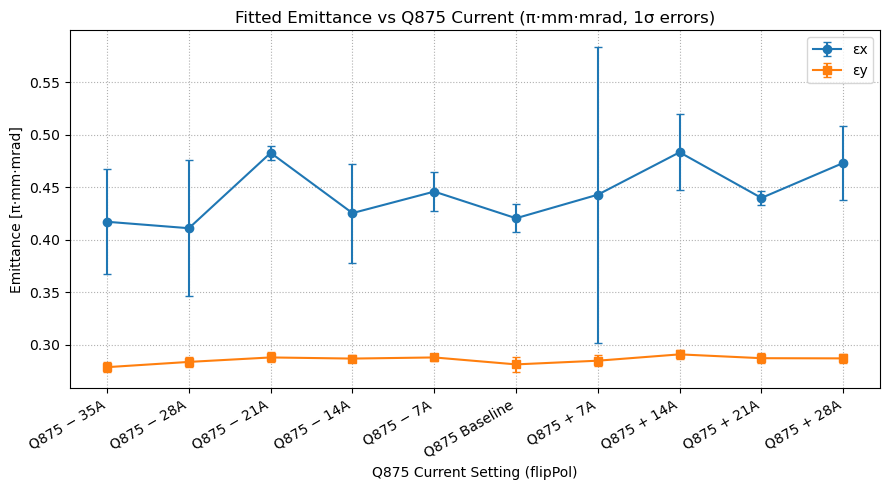

Wrote emittance_vs_Q875_current_flipPol_pi-mm-mrad.csv


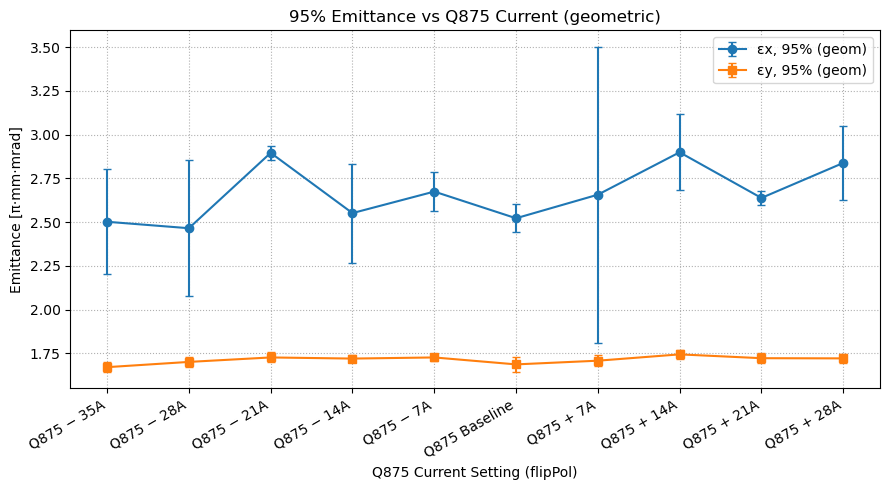

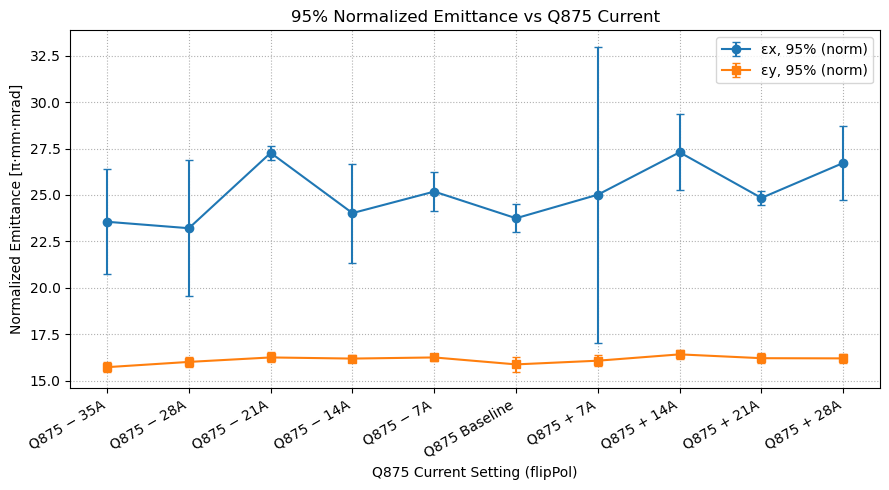

Wrote 95% geometric and normalized CSVs.
Wrote target_sigma_prediction_scaled_D_Q875_flipPol.csv


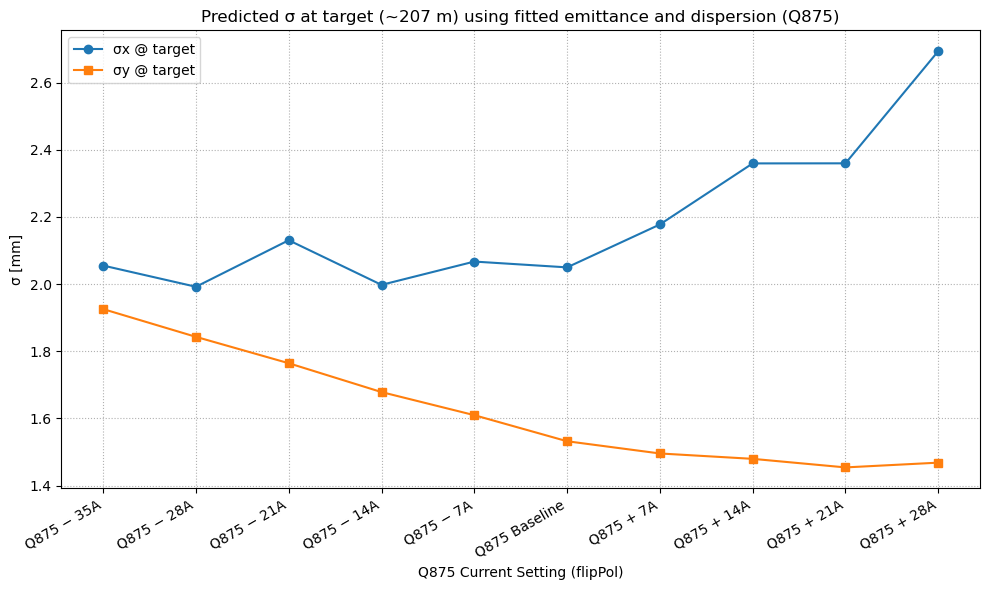

In [1]:
 # -*- coding: utf-8 -*-
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Config / constants
# =========================
MAGNET_FILE_TAG = "Q875"
MAGNET_LABEL    = "Q875"   # keep as "Q875" to match measurement row names
SWEEP_POLARITY  = "flipPol"

monitors = ["MW873","MW875","MW876"]

# =========================================
# SET MONITOR RESOLUTION HERE (mm)
# (subtracted in quadrature: sigma_corr^2 = sigma_meas^2 - sigma_res^2)
# Give a single number or a dict per wire if needed.
# =========================================
RES_H_MM = 0.00   # horizontal resolution (mm) or dict per wire
RES_V_MM = 0.00   # vertical   resolution (mm) or dict per wire
# Example per-wire override:
# RES_H_MM = {"MW873":0.00, "MW875":0.00, "MW876":0.00}
# RES_V_MM = {"MW873":0.00, "MW875":0.00, "MW876":0.00}

def get_res_mm(plane, wire):
    val = RES_H_MM if plane=="H" else RES_V_MM
    if isinstance(val, dict):
        return float(val.get(wire, 0.0))
    return float(val)

# =========================
# Q875 σ (mm) data
# Each list: [873 H, 873 V, 875 H, 875 V, 876 H, 876 V]
# (Entries include +35A; if the TFS for +35A is missing, that point will be skipped.)
# =========================
q875_data = {
    "Q875 − 35A":    [2.18, 4.95, 3.91, 1.43, 2.88, 1.08],
    "Q875 − 28A":    [2.17, 4.98, 3.96, 1.42, 2.94, 1.05],
    "Q875 − 21A":    [2.33, 5.01, 4.22, 1.41, 3.32, 1.03],
    "Q875 − 14A":    [2.20, 5.00, 4.06, 1.39, 3.15, 1.01],
    "Q875 − 7A":     [2.24, 5.00, 4.11, 1.37, 3.29, 0.984],
    "Q875 Baseline": [2.17, 4.96, 3.98, 1.37, 3.24, 0.939],
    "Q875 + 7A":     [2.21, 4.98, 4.14, 1.35, 3.66, 0.925],
    "Q875 + 14A":    [2.32, 5.01, 4.34, 1.33, 3.71, 0.90],
    "Q875 + 21A":    [2.22, 4.99, 4.22, 1.32, 3.61, 0.877],
    "Q875 + 28A":    [2.29, 5.01, 4.35, 1.31, 3.86, 0.850],
    "Q875 + 35A":    [2.23, 4.96, 4.30, 1.29, 3.80, 0.825],
}
meas_df = pd.DataFrame.from_dict(
    q875_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

# Build a robust index: map numeric current (float; 0.0 = baseline) -> measurement row
def build_meas_index(df):
    idx = {}
    # Example match strings: "Q875 Baseline", "Q875 + 28A", "Q875 − 7A"
    rx = re.compile(rf"{re.escape(MAGNET_LABEL)}\s*(baseline|([+\-−]?\s*\d+(?:\.\d+)?)\s*a)", re.IGNORECASE)
    for name in df.index:
        norm = name.replace("\u00A0"," ").replace("\u2009"," ")
        m = rx.search(norm)
        if not m:
            continue
        if m.group(1).lower().startswith("baseline"):
            key = 0.0
        else:
            s = m.group(2).replace("−","-").replace(" ","")
            key = float(s)
        idx[key] = df.loc[name]
    return idx

meas_by_current = build_meas_index(meas_df)

# =========================
# File discovery (flipPol sweep + optional baseline)
# Filenames listed (examples):
#   twiss_Q875_baseline_-35a_flipPol.tfs
#   twiss_Q875_baseline_+28a_flipPol.tfs
#   twiss_Q875_baseline_default_flipPol.tfs   <-- treat as 0 A
# =========================
def discover_sweep_files(polarity_tag):
    files = {}
    rx = re.compile(
        rf"^twiss_{MAGNET_FILE_TAG}_baseline_(?P<curr>[+\-]?\d+(?:\.\d+)?)a_{polarity_tag}\.tfs$",
        re.IGNORECASE
    )
    for nm in os.listdir("."):
        m = rx.match(nm)
        if m:
            curr = float(m.group("curr"))
            files[curr] = nm
    if not files:
        raise RuntimeError(f"No {MAGNET_LABEL} sweep files found for polarity '{polarity_tag}'.")
    return files

def find_baseline_file():
    # include 'baseline_default_flipPol.tfs'
    candidates = [
        f"twiss_{MAGNET_FILE_TAG}_baseline_default_{SWEEP_POLARITY}.tfs",
        f"twiss_{MAGNET_FILE_TAG}_baseline_{SWEEP_POLARITY}.tfs",
        f"twiss_{MAGNET_FILE_TAG}_baseline_flipPol.tfs",
        f"twiss_{MAGNET_FILE_TAG}_baseline.tfs",
        f"twiss_{MAGNET_FILE_TAG}_default.tfs",
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    return None

sweep_files = discover_sweep_files(SWEEP_POLARITY)
baseline_path = find_baseline_file()
if baseline_path is not None:
    sweep_files[0.0] = baseline_path  # add baseline if available

# =========================
# TFS reader & helpers
# =========================
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    header_idx = next(i for i,l in enumerate(lines) if l.lstrip().startswith("*"))
    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    data_rows = [ln for ln in lines[start:]
                 if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=[c.upper() for c in cols], engine="python")
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            raise RuntimeError(f"{w} not found in TFS")
        out[w] = m.iloc[0]
    return out

# ====== Fitting utilities with uncertainties ======
def subtract_resolution_mm(sig_mm, res_mm):
    s2 = sig_mm**2 - res_mm**2
    return math.sqrt(s2) if s2 > 0 else 0.0

def fit_two_param(sig_mm_list, beta_list, disp_list):
    # y = σ^2(m^2) = ε*β + σδ^2 * D^2
    y = np.array([(s*1e-3)**2 for s in sig_mm_list], float)
    X = np.column_stack([np.array(beta_list, float),
                         np.array(disp_list, float)**2])
    p, *_ = np.linalg.lstsq(X, y, rcond=None)
    eps, sdel2 = float(p[0]), float(p[1])

    r = y - X @ p
    N, P = X.shape
    dof = max(N - P, 1)
    rss = float(r.T @ r)
    s2 = rss / dof
    try:
        cov = s2 * np.linalg.inv(X.T @ X)
        std = np.sqrt(np.diag(cov))
        eps_std, sdel2_std = float(std[0]), float(std[1])
    except np.linalg.LinAlgError:
        eps_std, sdel2_std = float("nan"), float("nan")

    return max(eps,0.0), max(sdel2,0.0), eps_std, sdel2_std

def fit_one_param(sig_mm_list, beta_list):
    # y = ε*β; Var(ε) = s2 / (Σ β^2)
    y = np.array([(s*1e-3)**2 for s in sig_mm_list], float)
    X = np.array(beta_list, float).reshape(-1,1)
    denom = float((X.T @ X)[0,0])
    eps = float((X.T @ y)[0]) / denom if denom > 0 else 0.0
    r = y - X.flatten()*eps
    dof = max(len(y) - 1, 1)
    rss = float(r.T @ r)
    s2 = rss / dof
    eps_std = math.sqrt(s2/denom) if denom > 0 else float("nan")
    return max(eps,0.0), eps_std

COND_THRESH = 1e10
DY_THRESH   = 1e-3  # [m]

def label_for_current(I):
    if I == 0.0:
        return f"{MAGNET_LABEL} Baseline"
    sign = "+" if I > 0 else "−"  # U+2212
    val = int(abs(I)) if abs(I).is_integer() else abs(I)
    return f"{MAGNET_LABEL} {sign} {val}A"

# =========================
# Loop currents, subtract resolution, fit H & V
# =========================
results = []
xs, xtick_labels = [], []
epsx, epsx_std, epsy, epsy_std = [], [], [], []
sdx, sdx_std, sdy, sdy_std     = [], [], [], []

for I in sorted(sweep_files.keys()):
    if I not in meas_by_current:
        print(f"Skip {I:+g} A: no measurement row provided")
        continue

    path = sweep_files[I]
    df = read_tfs(path)
    rows = get_mw_rows(df)
    meas = meas_by_current[I]

    # Assemble per-wire optics
    betx = [float(rows[w]["BETX"]) for w in monitors]
    bety = [float(rows[w]["BETY"]) for w in monitors]
    dx   = [float(rows[w]["DX"])   for w in monitors]
    dy   = [float(rows[w]["DY"])   for w in monitors]

    # Measured sigmas with resolution subtraction (per plane and wire)
    sigx_mm, sigy_mm = [], []
    for w, short in zip(monitors, ["873","875","876"]):
        sx = float(meas[f"{short} H"])
        sy = float(meas[f"{short} V"])
        sigx_mm.append(subtract_resolution_mm(sx, get_res_mm("H", w)))
        sigy_mm.append(subtract_resolution_mm(sy, get_res_mm("V", w)))

    # --- Horizontal: 2-parameter fit (β, D^2)
    ex, sdx2, ex_std, sdx2_std = fit_two_param(sigx_mm, betx, dx)
    sdx_val   = math.sqrt(sdx2)
    sdx_stdev = 0.5*sdx2_std/math.sqrt(sdx2) if sdx2 > 0 and np.isfinite(sdx2_std) else float("nan")

    # --- Vertical: try 2-param; fallback to 1-param if ill-conditioned or tiny DY
    use_one_param_v = (max(abs(v) for v in dy) < DY_THRESH)
    if not use_one_param_v:
        Xv = np.column_stack([np.array(bety, float), np.array(dy, float)**2])
        try:
            cond = np.linalg.cond(Xv)
            use_one_param_v = cond > COND_THRESH
        except np.linalg.LinAlgError:
            use_one_param_v = True

    if use_one_param_v:
        ey, ey_s = fit_one_param(sigy_mm, bety)
        sdy_val, sdy_s = 0.0, 0.0
        fit_mode_y = "1-param (Dy≈0/ill-cond)"
    else:
        ey, sdy2, ey_s, sdy2_s = fit_two_param(sigy_mm, bety, dy)
        sdy_val   = math.sqrt(sdy2)
        sdy_s     = 0.5*sdy2_s/math.sqrt(sdy2) if sdy2 > 0 and np.isfinite(sdy2_s) else float("nan")
        fit_mode_y = "2-param"

    xs.append(I)
    xtick_labels.append(label_for_current(I))
    epsx.append(ex); epsx_std.append(ex_std)
    epsy.append(ey); epsy_std.append(ey_s)
    sdx.append(sdx_val); sdx_std.append(sdx_stdev)
    sdy.append(sdy_val); sdy_std.append(sdy_s)

    results.append({
        "Current [A]": I,
        "Label": label_for_current(I),
        "eps_x [m rad]": ex,  "eps_x_std [m rad]": ex_std,
        "eps_y [m rad]": ey,  "eps_y_std [m rad]": ey_s,
        "sigma_delta_x": sdx_val, "sigma_delta_x_std": sdx_stdev,
        "sigma_delta_y": sdy_val, "sigma_delta_y_std": sdy_s,
        "fit_mode_y": fit_mode_y,
        "TFS file": os.path.basename(path),
    })

# =========================
# Save base CSV
# =========================
res_df = pd.DataFrame(results).set_index("Label")
out_base = f"emittance_vs_{MAGNET_FILE_TAG}_current_{SWEEP_POLARITY}_with_errors.csv"
res_df.to_csv(out_base)
print(f"Wrote {out_base}")

# =========================
# Plots with error bars (π·mm·mrad)
# =========================
xs_np = np.array(xs, dtype=float)
scale_pi_mm_mrad = 1e6 / math.pi  # m·rad -> π·mm·mrad

epsx_pi   = np.array(epsx)     * scale_pi_mm_mrad
epsy_pi   = np.array(epsy)     * scale_pi_mm_mrad
epsx_pi_e = np.array(epsx_std) * scale_pi_mm_mrad
epsy_pi_e = np.array(epsy_std) * scale_pi_mm_mrad

plt.figure(figsize=(9,5))
plt.errorbar(xs_np, epsx_pi, yerr=epsx_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx")
plt.errorbar(xs_np, epsy_pi, yerr=epsy_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [π·mm·mrad]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"Fitted Emittance vs {MAGNET_LABEL} Current (π·mm·mrad, 1σ errors)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

emi_out = pd.DataFrame({
    "eps_x [π·mm·mrad]": epsx_pi,
    "eps_x_std [π·mm·mrad]": epsx_pi_e,
    "eps_y [π·mm·mrad]": epsy_pi,
    "eps_y_std [π·mm·mrad]": epsy_pi_e,
}, index=xtick_labels)
out_pi = f"emittance_vs_{MAGNET_FILE_TAG}_current_{SWEEP_POLARITY}_pi-mm-mrad.csv"
emi_out.to_csv(out_pi)
print(f"Wrote {out_pi}")

# ---- 95% emittance from rms results ----
F95 = 6.0  # 95% ≈ 6 × rms (FNAL convention)
p_GeV = 8.83490
m_GeV = 0.9382720813
bg = p_GeV / m_GeV          # βγ

epsx95_pi   = F95 * np.array(epsx)     * scale_pi_mm_mrad
epsy95_pi   = F95 * np.array(epsy)     * scale_pi_mm_mrad
epsx95_pi_e = F95 * np.array(epsx_std) * scale_pi_mm_mrad
epsy95_pi_e = F95 * np.array(epsy_std) * scale_pi_mm_mrad

epsx95n_pi   = epsx95_pi   * bg
epsy95n_pi   = epsy95_pi   * bg
epsx95n_pi_e = epsx95_pi_e * bg
epsy95n_pi_e = epsy95_pi_e * bg

# ---- Plot geometric 95% ----
plt.figure(figsize=(9,5))
plt.errorbar(xs_np, epsx95_pi, yerr=epsx95_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx, 95% (geom)")
plt.errorbar(xs_np, epsy95_pi, yerr=epsy95_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy, 95% (geom)")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [π·mm·mrad]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"95% Emittance vs {MAGNET_LABEL} Current (geometric)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot normalized 95% ----
plt.figure(figsize=(9,5))
plt.errorbar(xs_np, epsx95n_pi, yerr=epsx95n_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx, 95% (norm)")
plt.errorbar(xs_np, epsy95n_pi, yerr=epsy95n_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy, 95% (norm)")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("Normalized Emittance [π·mm·mrad]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"95% Normalized Emittance vs {MAGNET_LABEL} Current")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Save 95% CSVs ----
pd.DataFrame({
    "epsx_95_geom [π·mm·mrad]": epsx95_pi,
    "epsx_95_geom_std [π·mm·mrad]": epsx95_pi_e,
    "epsy_95_geom [π·mm·mrad]": epsy95_pi,
    "epsy_95_geom_std [π·mm·mrad]": epsy95_pi_e,
}, index=xtick_labels).to_csv(f"emittance95_geometric_{MAGNET_FILE_TAG}_{SWEEP_POLARITY}_pi-mm-mrad.csv")

pd.DataFrame({
    "epsx_95_norm [π·mm·mrad]": epsx95n_pi,
    "epsx_95_norm_std [π·mm·mrad]": epsx95n_pi_e,
    "epsy_95_norm [π·mm·mrad]": epsy95n_pi,
    "epsy_95_norm_std [π·mm·mrad]": epsy95n_pi_e,
}, index=xtick_labels).to_csv(f"emittance95_normalized_{MAGNET_FILE_TAG}_{SWEEP_POLARITY}_pi-mm-mrad.csv")

print("Wrote 95% geometric and normalized CSVs.")


# =========================================================
# 9) Predict σx, σy at target (~207 m) using fitted emittance & σδ
# =========================================================
target_results = []

def pick_target_row(df):
    for n in ["MTGT","MWTGT","TARGET","TGT","MTGT1"]:
        m = df[df["NAME"]==n]
        if not m.empty:
            return m.iloc[0]
    # fallback by S≈207 m
    if "S" in df.columns:
        near = df.iloc[(df["S"]-207.0).abs().idxmin()]
        return near
    raise RuntimeError("Target not found")

for I, lbl in zip(xs, xtick_labels):
    if I not in sweep_files:
        continue
    df = read_tfs(sweep_files[I])
    tgt = pick_target_row(df)

    bx, by = float(tgt["BETX"]), float(tgt["BETY"])
    Dx, Dy = float(tgt["DX"]), float(tgt["DY"])

    ex = epsx[xs.index(I)]
    ey = epsy[xs.index(I)]
    sdx_val = sdx[xs.index(I)]
    sdy_val = sdy[xs.index(I)]

    sigx_mm = math.sqrt(max(ex*bx + (sdx_val*Dx)**2, 0.0))*1e3
    sigy_mm = math.sqrt(max(ey*by + (sdy_val*Dy)**2, 0.0))*1e3

    target_results.append({
        "Label": lbl,
        "σx [mm]": sigx_mm,
        "σy [mm]": sigy_mm,
        "BETX": bx, "BETY": by, "DX": Dx, "DY": Dy,
    })

tgt_df = pd.DataFrame(target_results).set_index("Label")
tgt_csv = f"target_sigma_prediction_scaled_D_{MAGNET_FILE_TAG}_{SWEEP_POLARITY}.csv"
tgt_df.to_csv(tgt_csv)
print(f"Wrote {tgt_csv}")

# =========================================================
# 10) Plot σx, σy vs current
# =========================================================
plt.figure(figsize=(10,6))
plt.plot(xs_np, tgt_df["σx [mm]"], marker="o", label="σx @ target")
plt.plot(xs_np, tgt_df["σy [mm]"], marker="s", label="σy @ target")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("σ [mm]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"Predicted σ at target (~207 m) using fitted emittance and dispersion ({MAGNET_LABEL})")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

